# Kaggle: Invasive Species Competition 

## Setup

In [1]:
% matplotlib inline 

from __future__ import division, print_function 

import os, json
import numpy as np 
from matplotlib import pyplot as plt

import pandas

import cv2
 
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.optimizers import Adam
from keras import models 
from keras.layers.normalization import BatchNormalization


from sklearn import metrics

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


# Making the VGG model

In [2]:
def Vgg(): 
    # it's going to be a sequential model - a stack of layers
    # I can add layers to this model using the .add() method
    
    def ConvLayer(model, num_filters, **kwargs):
        #As with any neural network, I need to add a bias node
        #Since the input is an image, we'll use 2D padding and layers
        model.add(ZeroPadding2D(padding = (1,1), **kwargs))
        # The layers are 3x3 conv layers, with 64 - 512 filters
        model.add(Conv2D(num_filters, 3, 3, activation = 'relu'))
    
    def FCL(model, num_filters):
        # In Keras, a fully connected layer is called 'Dense' 
        model.add(Dense(num_filters, activation = 'relu'))
        #A dropout layer for the FIRST TWO fully connected layers is added
        # with a dropout ratio set at 0.5
        model.add(Dropout(0.5))
    
    def mean_center(x):
        vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
        x = x - vgg_mean     # subtract mean
        return x[:, ::-1]    # reverse axis bgr->rgb
    
    VGG_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
    
    def vgg_preprocess(x, VGG_mean):
        VGG_mean = np.asarray(VGG_mean)
        x = x - VGG_mean
        return x[:, ::-1] # reverse axis bgr->rgb
    
    model = Sequential()
    
    model.add(Lambda(vgg_preprocess, arguments={'VGG_mean': VGG_mean.tolist()}, input_shape = (3,224,224)))
    
    #Now, I add all the layers according to the architecture 
    #In the first layer, I need to define the input type of the images
    
    ConvLayer(model, 64, input_shape = (3,224,224))
    ConvLayer(model, 64)
    
    #After every bunch of convolutional layers, there's a maxpooling layer 
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    
    ConvLayer(model, 128)
    ConvLayer(model, 128)
    
    model.add(MaxPooling2D(pool_size=(2,2), strides =(2,2)))
    
    ConvLayer(model, 256)
    ConvLayer(model, 256)
    ConvLayer(model, 256)
    
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    
    ConvLayer(model, 512)
    ConvLayer(model, 512)
    ConvLayer(model, 512)
    
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
        
    ConvLayer(model, 512)
    ConvLayer(model, 512)
    ConvLayer(model, 512)
    
    model.add(MaxPooling2D(pool_size=(2,2), strides = (2,2)))
    
    #Now, as we go from the convolutional layer to the fully connected layer, this is in 1D not 3D
    #So we have to flatten the inputs
    
    model.add(Flatten())
    FCL(model, 4096)
    FCL(model, 4096)
    #Finally, the last layer, which is a softmax layer
    model.add(Dense(1000, activation = 'softmax'))
    
    #Now, I need to add the weights

    fpath = get_file('vgg16.h5', 'http://files.fast.ai/models/vgg16.h5', cache_subdir='models')
    model.load_weights(fpath)
        
    return model

## Applying this model to the invasive species competition

### Augmenting the Data

In [3]:
batch_size = 32

train_gen = image.ImageDataGenerator(horizontal_flip = True,
                               rotation_range = 30,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                                height_shift_range = 0.1,
                                width_shift_range = 0.1

)


batches = train_gen.flow_from_directory("data/invasive/train", 
                                        target_size = (224, 224), 
                                        batch_size = batch_size
                                       )

valid_gen = image.ImageDataGenerator()

valid_batches = valid_gen.flow_from_directory("data/invasive/valid", 
                                              target_size = (224, 224), 
                                              batch_size = batch_size
                                             )

Found 2095 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Using the data to train the model 

In [4]:
vgg = Vgg()

vgg.pop()
vgg.add(Dense(2, activation = 'softmax'))

#only allowing the last layer to be trained: 

for layer in vgg.layers[:25]: layer.trainable = False
    
#compiling the model with my parameters: 
vgg.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])



history = History()

history = vgg.model.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 50, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([history,
                                                ModelCheckpoint('/home/ubuntu/INV-VGG1.model', 
                                                                monitor='val_acc', 
                                                                save_best_only=True),
                                                EarlyStopping(monitor='val_acc', patience = 5)
                                               ]))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


Epoch 1/50
2095/2095 [==============================] - 91s - loss: 0.4102 - acc: 0.8740 - val_loss: 0.1796 - val_acc: 0.9450
Epoch 2/50
2095/2095 [==============================] - 100s - loss: 0.2291 - acc: 0.9236 - val_loss: 0.2457 - val_acc: 0.9500
Epoch 3/50
2095/2095 [==============================] - 96s - loss: 0.1666 - acc: 0.9499 - val_loss: 0.1118 - val_acc: 0.9700
Epoch 4/50
2095/2095 [==============================] - 79s - loss: 0.1282 - acc: 0.9556 - val_loss: 0.1133 - val_acc: 0.9550
Epoch 5/50
2095/2095 [==============================] - 78s - loss: 0.0961 - acc: 0.9680 - val_loss: 0.1721 - val_acc: 0.9500
Epoch 6/50
2095/2095 [==============================] - 81s - loss: 0.1095 - acc: 0.9609 - val_loss: 0.1397 - val_acc: 0.9600
Epoch 7/50
2095/2095 [==============================] - 86s - loss: 0.1158 - acc: 0.9566 - val_loss: 0.0956 - val_acc: 0.9700
Epoch 8/50
2095/2095 [==============================] - 80s - loss: 0.1073 - acc: 0.9690 - val_loss: 0.1675 - val_acc

## Removing the dropout layers

In [ ]:
def vgg_bn(dropout = 0.5):
    prev_vgg = load_model('/home/ubuntu/invasive_vgg.model')
    
    #returns a vgg model with batch normalization and a defined dropout
    #the weights are adjusted to whichever dropout you select
    
    prev_layers = prev_vgg.layers[:-5]
    new_vgg = Sequential(prev_layers)
    
    def new_FCL(model, num_filters, dropout):
        # In Keras, a fully connected layer is called 'Dense' 
        model.add(Dense(num_filters, activation = 'relu'))
        #A dropout layer for the FIRST TWO fully connected layers is added
        # with a dropout ratio to be defined
        model.add(Dropout(dropout))
        
    new_FCL(bn_vgg, 4096, dropout)
    BatchNormalization()
    new_FCL(bn_vgg, 4096, dropout)
    BatchNormalization()
    bn_vgg.add(Dense(2, activation = 'softmax'))
    
    for layer in zip(prev_vgg.layers[-5:], new_vgg.layers[-5:]):
    # the new weights are the second element in the tuple
    layer[1].set_weights([(0.5/dropout)*x for x in layer[0].get_weights()])
    
    return new_vgg
    
    

In [28]:
prev_vgg.layers[-6]

In [58]:
prev_layers = prev_vgg.layers[:-5]
new_vgg = Sequential(prev_layers)
new_vgg.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]                   
                                                                   lambda_1[0][0]          

Next, I want to add a the dropout layers again, but without any dropout

In [29]:
def new_FCL(model, num_filters, dropout):
        # In Keras, a fully connected layer is called 'Dense' 
        model.add(Dense(num_filters, activation = 'relu'))
        #A dropout layer for the FIRST TWO fully connected layers is added
        # with a dropout ratio to be defined
        model.add(Dropout(dropout))

In [59]:
new_FCL(new_vgg, 4096, 0)
new_FCL(new_vgg, 4096, 0)
new_vgg.add(Dense(2, activation = 'softmax'))

Excellent. Now that I've done this, I need to add the weights, but HALVE them. 

In [34]:
len(prev_vgg.layers) , len(new_vgg.layers)

(38, 38)

Since both vgg models have the same number of layers, I can just equate the two

In [60]:
for layer in zip(prev_vgg.layers[-5:], new_vgg.layers[-5:]):
    # the new weights are the second element in the tuple
    layer[1].set_weights([x/2 for x in layer[0].get_weights()])

In [65]:
for layer in new_vgg.layers[:-5]: layer.trainable = False
    
new_vgg.compile(optimizer=Adam(lr=0.00001),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [66]:
history = History()

history = new_vgg.model.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 50, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([history,
                                                ModelCheckpoint('/home/ubuntu/invasive_new_vgg.model', 
                                                                monitor='val_acc', 
                                                                save_best_only=True),
                                                EarlyStopping(monitor='val_acc', patience = 5)
                                               ]))

Epoch 1/50
2095/2095 [==============================] - 95s - loss: 0.0215 - acc: 0.9919 - val_loss: 0.1724 - val_acc: 0.9700
Epoch 2/50
2095/2095 [==============================] - 89s - loss: 0.0139 - acc: 0.9952 - val_loss: 0.1302 - val_acc: 0.9750
Epoch 3/50
2095/2095 [==============================] - 79s - loss: 0.0165 - acc: 0.9943 - val_loss: 0.1480 - val_acc: 0.9650
Epoch 4/50
2095/2095 [==============================] - 85s - loss: 0.0165 - acc: 0.9938 - val_loss: 0.2014 - val_acc: 0.9700
Epoch 5/50
2095/2095 [==============================] - 83s - loss: 0.0174 - acc: 0.9928 - val_loss: 0.1088 - val_acc: 0.9750
Epoch 6/50
2095/2095 [==============================] - 79s - loss: 0.0135 - acc: 0.9962 - val_loss: 0.1814 - val_acc: 0.9600
Epoch 7/50
2095/2095 [==============================] - 85s - loss: 0.0118 - acc: 0.9947 - val_loss: 0.0839 - val_acc: 0.9750
Epoch 8/50
2095/2095 [==============================] - 86s - loss: 0.0168 - acc: 0.9952 - val_loss: 0.1889 - val_acc:

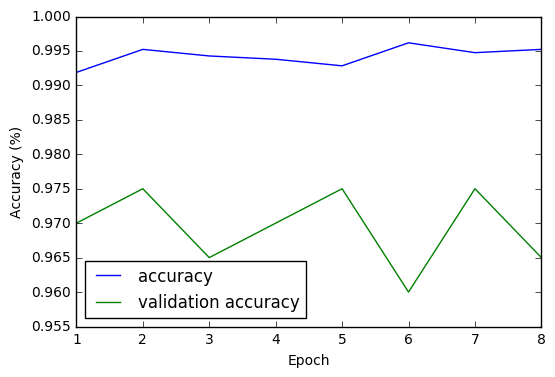

In [82]:
plt.plot(range(1,9), history.history['acc'], label = 'accuracy')
plt.plot(range(1,9), history.history['val_acc'], label = 'validation accuracy')
plt.legend(loc = 'lower left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.show()

## wtf. Let's try batch normalization

In [99]:
prev_layers = prev_vgg.layers[:-5]
bn_vgg = Sequential(prev_layers)

In [100]:
from keras.layers.normalization import BatchNormalization

new_FCL(bn_vgg, 4096, 0.5)
BatchNormalization()
new_FCL(bn_vgg, 4096, 0.5)
BatchNormalization()
bn_vgg.add(Dense(2, activation = 'softmax'))

In [88]:
len(bn_vgg.layers)

38

In [5]:
import numpy as np
all_preds = np.asarray([])
all_preds.size

0

In [101]:
for layer in zip(prev_vgg.layers[-5:], bn_vgg.layers[-5:]): 
    # the new weights are the second element in the tuple
    layer[1].set_weights([x for x in layer[0].get_weights()])

In [102]:
for layer in bn_vgg.layers[:-5]: layer.trainable = False
    
bn_vgg.compile(optimizer=Adam(lr=0.00001),
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [103]:
bn_history = History()

bn_history = bn_vgg.model.fit_generator(generator =batches, 
                                  samples_per_epoch=batches.nb_sample, 
                                  nb_epoch = 50, 
                                  validation_data=valid_batches, 
                                  nb_val_samples=valid_batches.nb_sample, 
                                  callbacks = ([bn_history,
                                                ModelCheckpoint('/home/ubuntu/invasive_bn_vgg.model', 
                                                                monitor='val_acc', 
                                                                save_best_only=True),
                                                EarlyStopping(monitor='val_acc', patience = 5)
                                               ]))

Epoch 1/50
2095/2095 [==============================] - 104s - loss: 0.0233 - acc: 0.9952 - val_loss: 0.2120 - val_acc: 0.9600
Epoch 2/50
2095/2095 [==============================] - 83s - loss: 0.0102 - acc: 0.9952 - val_loss: 0.1656 - val_acc: 0.9550
Epoch 3/50
2095/2095 [==============================] - 81s - loss: 0.0146 - acc: 0.9938 - val_loss: 0.2405 - val_acc: 0.9550
Epoch 4/50
2095/2095 [==============================] - 99s - loss: 0.0361 - acc: 0.9928 - val_loss: 0.2645 - val_acc: 0.9700
Epoch 5/50
2095/2095 [==============================] - 96s - loss: 0.0260 - acc: 0.9909 - val_loss: 0.2120 - val_acc: 0.9750
Epoch 6/50
2095/2095 [==============================] - 98s - loss: 0.0196 - acc: 0.9938 - val_loss: 0.0871 - val_acc: 0.9800
Epoch 7/50
2095/2095 [==============================] - 77s - loss: 0.0128 - acc: 0.9952 - val_loss: 0.1820 - val_acc: 0.9700
Epoch 8/50
2095/2095 [==============================] - 83s - loss: 0.0103 - acc: 0.9971 - val_loss: 0.2692 - val_acc

In [108]:
final_vgg = load_model('/home/ubuntu/invasive_bn_vgg.model')

### Creating data for Kaggle Submission

In [109]:
test_batches = valid_gen.flow_from_directory("data/invasive/Test", 
                                             target_size=(224,224), 
                                             batch_size = 8, 
                                             shuffle = False)
filenames = test_batches.filenames
batches.class_indices

Found 1531 images belonging to 1 classes.


{'inv': 0, 'non_inv': 1}

In [110]:
test_preds = final_vgg.predict_generator(test_batches, test_batches.nb_sample)

In [6]:
is_inv = [(i[0]) for i in test_preds]
#is_inv = np.clip(is_inv, 0.05, 0.95)
ids = [int(f[5:f.find('.')]) for f in filenames]
combined = np.column_stack((ids, is_inv))

NameError: name 'test_preds' is not defined

In [112]:
np.savetxt("data/invasive/submission3.csv", combined, fmt="%d,%.5f", header = 'name,invasive')